
# Simulating PV system DC output using the ADR module efficiency model

Time series processing with the ADR model is really easy.

This example reads a TMY3 weather file, and runs a basic simulation
on a fixed latitude-tilt system.
Efficiency is independent of system size, so adjusting the system
capacity is just a matter of setting the desired value, e.g. P_STC = 5000.

Author: Anton Driesse


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pvlib
from pvlib import iotools, location
from pvlib.irradiance import get_total_irradiance
from pvlib.pvarray import pvefficiency_adr

Read a TMY3 file containing weather data and select needed columns




In [2]:
PVLIB_DIR = pvlib.__path__[0]
DATA_FILE = os.path.join(PVLIB_DIR, 'data', '723170TYA.CSV')

tmy, metadata = iotools.read_tmy3(DATA_FILE, coerce_year=1990,
                                  map_variables=True)

df = pd.DataFrame({'ghi': tmy['ghi'], 'dhi': tmy['dhi'], 'dni': tmy['dni'],
                   'temp_air': tmy['temp_air'],
                   'wind_speed': tmy['wind_speed'],
                   })

Shift timestamps to middle of hour and then calculate sun positions




In [3]:
df.index = df.index - pd.Timedelta(minutes=30)

loc = location.Location.from_tmy(metadata)
solpos = loc.get_solarposition(df.index)

Determine  total irradiance on a fixed-tilt array




In [4]:
TILT = metadata['latitude']
ORIENT = 180

total_irrad = get_total_irradiance(TILT, ORIENT,
                                   solpos.apparent_zenith, solpos.azimuth,
                                   df.dni, df.ghi, df.dhi)

df['poa_global'] = total_irrad.poa_global

Estimate the expected operating temperature of the PV modules




In [5]:
df['temp_pv'] = pvlib.temperature.faiman(df.poa_global, df.temp_air,
                                         df.wind_speed)

Now we're ready to calculate PV array DC output power based
on POA irradiance and PV module operating temperature.
Among the models available in pvlib-python to do this are:

 - PVWatts
 - SAPM
 - single-diode model variations

And now also the ADR PV efficiency model

Simulation is done in two steps:

 - first calculate efficiency using the ADR model,
 - then convert (scale up) efficiency to power.




In [6]:
# Borrow the ADR model parameters from the other example:

adr_params = {'k_a': 0.99924,
              'k_d': -5.49097,
              'tc_d': 0.01918,
              'k_rs': 0.06999,
              'k_rsh': 0.26144
              }

df['eta_rel'] = pvefficiency_adr(df['poa_global'], df['temp_pv'], **adr_params)

# Set the desired array size:
P_STC = 5000.   # (W)

# and the irradiance level needed to achieve this output:
G_STC = 1000.   # (W/m2)

df['p_mp'] = P_STC * df['eta_rel'] * (df['poa_global'] / G_STC)

Show how power and efficiency vary with both irradiance and temperature




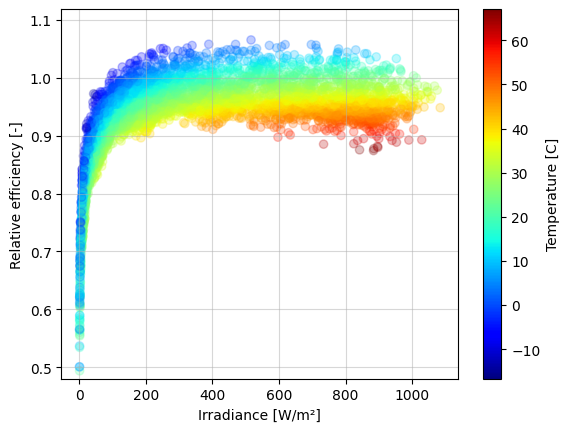

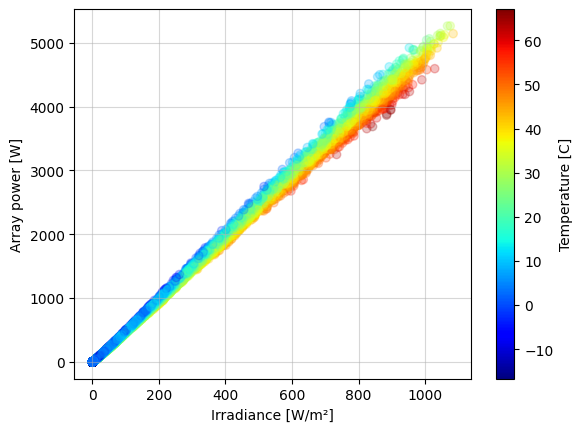

In [7]:
plt.figure()
pc = plt.scatter(df['poa_global'], df['eta_rel'], c=df['temp_pv'], cmap='jet')
plt.colorbar(label='Temperature [C]', ax=plt.gca())
pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.ylim(0.48)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Relative efficiency [-]')
plt.show()

plt.figure()
pc = plt.scatter(df['poa_global'], df['p_mp'], c=df['temp_pv'], cmap='jet')
plt.colorbar(label='Temperature [C]', ax=plt.gca())
pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Array power [W]')
plt.show()

One day:




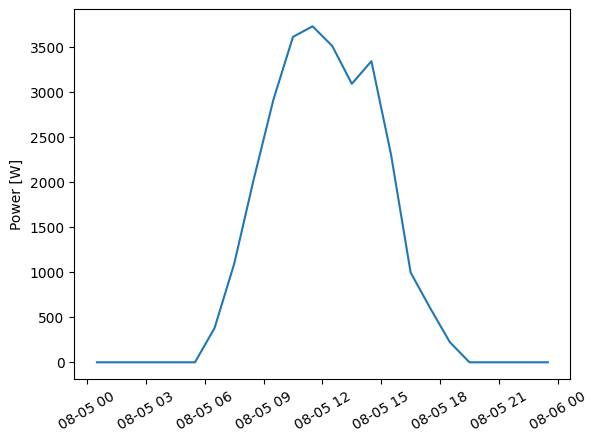

In [8]:
DEMO_DAY = '1990-08-05'

plt.figure()
plt.plot(df['p_mp'][DEMO_DAY])
plt.xticks(rotation=30)
plt.ylabel('Power [W]')
plt.show()

## References
.. [1] A. Driesse and J. S. Stein, "From IEC 61853 power measurements
   to PV system simulations", Sandia Report No. SAND2020-3877, 2020.
   :doi:`10.2172/1615179`

.. [2] A. Driesse, M. Theristis and J. S. Stein, "A New Photovoltaic Module
   Efficiency Model for Energy Prediction and Rating," in IEEE Journal
   of Photovoltaics, vol. 11, no. 2, pp. 527-534, March 2021.
   :doi:`10.1109/JPHOTOV.2020.3045677`


